## Quantum Simulation in Imaginary Time for Gauge-Invariant Models: A Deterministic Approach for Imaginary-Time Evolution on Quantum Hardware  - *Experimental Quantum Circuit Implementation* 

### How to Read and Use This Notebook
This notebook is organized to give a somewhat thorough review to deterministic imaginary-time evolution (ITE) on quantum computers, a [framework developed by Daniele Cuomo.](https://zenodo.org/records/17092508)  
It is written to be rigorous yet accessible to students with basic quantum computing background.

As a deliverable for the Qiskit Advocate Mentorship Program (QAMP), this notebook is the implementation companion to `Notebook_Theory_v1.ipynb`.  
The goal here is practical: map each theoretical ingredient to concrete Qiskit objects in the `gauge_simulation` package, then run and analyze full end-to-end simulations.

---


### Quick-start: Run a Complete Cuomo-Framework ITE Simulation (TFIM)

This section is a “minimal-but-explained” end-to-end run of the `gauge_simulation` package.

We will:

1. **Build** a TFIM `GaugeModel` object (this constructs the Hamiltonian *and* the parameterized ITE circuit)
2. Compute:
   - **Exact** ground-state energy (exact diagonalization)
   - **Approximate** ground-state energy (from the circuit workflow)
3. Compute thermal quantities vs inverse temperature $\beta$:
   - Exact thermodynamics (exact diagonalization)
   - Circuit-based thermodynamics (Cuomo-style ITE simulation)
4. Optionally **draw the circuit** and **plot** the results.

**Where this is implemented in the package**
- Model construction: `models.build_hamiltonian()`  (in `models.py`)
- Core circuit + observables construction: `core.tfim_generalized()` (in `core.py`)
- Exact & simulated thermodynamics + utilities: methods of `GaugeModel` (in `hamiltonian.py`)
- Plotting helper: `plotting.plot_simulation_results()` (in `plotting.py`)

> Note: `lattice_size = [rows, cols]`.  
> Use `[1, n]` or `[n, 1]` for a 1D chain of length $n$, and `[L_x, L_y]` for a 2D lattice with $n=L_xL_y$.


In [12]:
import numpy as np

# Package imports
from gauge_simulation import models
from gauge_simulation.engine import Engine
from gauge_simulation.backend import LocalBackend


model = "tfim"
lattice_size = [2, 2]
trotter_steps = 2
beta_vals = np.linspace(0.0, 1.4, 11)


# -------------------------------------------------
# Build model (data container)
# -------------------------------------------------

H = models.build_hamiltonian(
    model,
    lattice_size,
    trotter_steps=trotter_steps
)

backend = LocalBackend()
engine = Engine(backend)

exact_groundstate = H.exact_ground_state()

approx_groundstate = engine.approximate_ground_state(H)

print(f"Exact Ground State Energy:      {exact_groundstate:.6f}")
print(f"Approx. Ground State Energy:    {approx_groundstate:.6f}")

Exact Ground State Energy:      -4.104689
Approx. Ground State Energy:    -3.718389


### What you should notice from this quick-start

- `models.build_hamiltonian()` is the *single entry point* that creates the full simulation object.
- The returned `GaugeModel` contains both:
  - **exact** thermodynamics (diagonalization-based), and
  - **ITE circuit simulation** (ITE via auxiliary qubits + measurement).
- In the next section, we will go in-depth and explain how the package decides:
  - how many qubits are required,
  - how the registers are laid out (system / purification / auxiliary),
  - and how the TFIM terms determine the auxiliary-qubit count.


### Resource Accounting 

Before we inspect circuit construction, we must determine how many qubits the algorithm allocates and why. In Cuomo’s framework (as implemented in this package), the circuit width is not just the number of physical spins $n$. It includes:

1. **System register** (physical spins):  
   $$ n = L_x L_y $$

2. **Purification register** (to prepare a maximally mixed state on the system):  
   $$ n \text{ additional qubits} $$

3. **Auxiliary register** (measurement-induced non-unitary steps):  one auxiliary qubit per Hamiltonian term.

So the *core resource rule* used throughout the package is:

$$ N_{\text{total}} = 2n + N_{\text{terms}}, $$

where $N_{\text{terms}}$ is the number of Pauli terms in the Hamiltonian. For the Transverse Field Ising Model (TFIM),

$$H_{\text{TFIM}} = \sum_{j} \gamma_{j}(Z_j \otimes Z_{j+1}) + \eta \sum_{j} X_j.$$

the Hamiltonian terms are of two types:

- **Field terms** $X_i$: always exactly
  $$ N_X = n. $$

- **Nearest-neighbor interactions** $Z_i Z_j$: depend on geometry.
  
Rather than hard-coding formulas for 1D vs 2D bonds, the package computes the interaction list using the function:

- `get_nearest_neighbor_interactions(lattice_size)`  (in `core.py`)

This function returns a list of nearest neighbors index pairs $(j,j+1)$. Each pair corresponds to one $Z_j \otimes Z_{j+1}$ interaction term, so:

$$ N_{ZZ} = \texttt{len(get\_nearest\_neighbor\_interactions(lattice\_size))}.$$

Therefore the TFIM term count used by the code is:

$$N_{\text{terms}} = N_X + N_{ZZ} = n + N_{ZZ}.$$

In the next cell, we call the package function directly and compute these numbers exactly the way the implementation does. To make the resource counting and Hamiltonian construction more intuitive, we will visualize the lattice geometry implied by `lattice_size` and draw the nearest-neighbor interaction graph used by the package.



lattice_size = [1, 6]
n spins      = 6
N_ZZ terms   = 5
N_X terms    = 6
N_terms      = 11
TOTAL qubits = 23
ZZ pairs     = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]


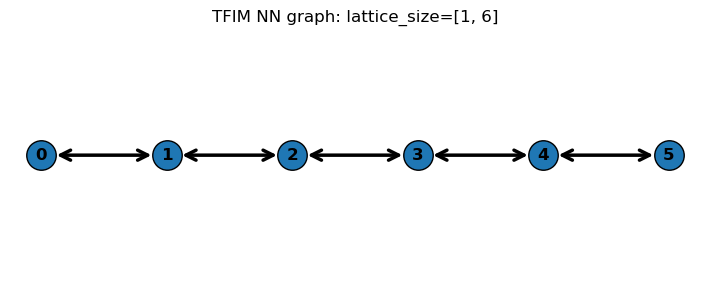


lattice_size = [3, 3]
n spins      = 9
N_ZZ terms   = 12
N_X terms    = 9
N_terms      = 21
TOTAL qubits = 39
ZZ pairs     = [(0, 1), (0, 3), (1, 2), (1, 4), (2, 5), (3, 4), (3, 6), (4, 5), (4, 7), (5, 8), (6, 7), (7, 8)]


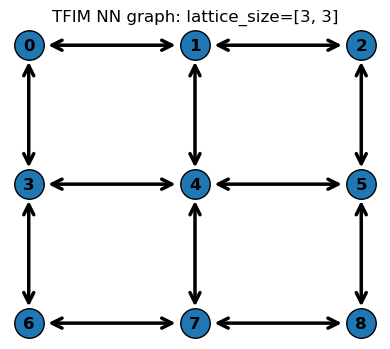

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

from gauge_simulation.core import get_nearest_neighbor_interactions

def lattice_positions(lattice_size):
    """Row-major indexing: index = row * Ly + col"""
    Lx, Ly = lattice_size
    pos = {}
    idx = 0
    for r in range(Lx):
        for c in range(Ly):
            pos[idx] = (c, -r)
            idx += 1
    return pos

def plot_lattice_with_interactions(lattice_size, interaction_pairs, title=None):
    pos = lattice_positions(lattice_size)
    Lx, Ly = lattice_size
    n = Lx * Ly

    # fig, ax = plt.subplots(figsize=(max(4, Ly*1.2), max(3, Lx*1.2)))
    fig = plt.figure(figsize=(max(4, Ly*1.2), max(3, Lx*1.2)))
    ax = plt.subplot(1,1,1)

    # double-headed arrows for NN interactions
    for (i, j) in interaction_pairs:
        xi, yi = pos[i]
        xj, yj = pos[j]

        dx, dy = xj - xi, yj - yi
        length = (dx**2 + dy**2)**0.5
        offset = 0.1

        ux, uy = dx/length, dy/length

        start = (xi + offset * ux, yi + offset * uy)
        end   = (xj - offset * ux, yj - offset * uy)

        ax.add_patch(
            FancyArrowPatch(
                start, end,
                arrowstyle="<->",
                linewidth=2.5,
                mutation_scale=18
            )
        )

    # nodes
    xs = [pos[i][0] for i in range(n)]
    ys = [pos[i][1] for i in range(n)]
    ax.scatter(xs, ys, s=450, edgecolors="k", zorder=3)

    # labels
    for i in range(n):
        x, y = pos[i]
        ax.text(x, y, str(i), ha="center", va="center",
                fontsize=12, fontweight="bold", zorder=4)
    ax.axis("off")
    ax.set_title(title if title else f"Lattice {lattice_size} with NN interactions")
    plt.tight_layout()
    plt.show()

def resource_count_tfim(lattice_size):
    """
    Compute TFIM resource counts *exactly* the way the package determines geometry:
    ZZ interactions come from get_nearest_neighbor_interactions(lattice_size).
    """
    n = lattice_size[0] * lattice_size[1]
    zz_pairs = get_nearest_neighbor_interactions(lattice_size)

    N_ZZ = len(zz_pairs)
    N_X  = n
    N_terms = N_X + N_ZZ
    N_total = 2*n + N_terms

    return {
        "lattice_size": lattice_size,
        "n_spins": n,
        "zz_pairs": zz_pairs,
        "N_ZZ": N_ZZ,
        "N_X": N_X,
        "N_terms": N_terms,
        "N_total_qubits": N_total,
    }

# Examples: 1D and 2D

infos = [
    resource_count_tfim([1, 6]),  # 1D chain of length 6
    resource_count_tfim([3, 3]),  # 2D 3x3 square lattice 
]

for info in infos:
    print("\n==============================")
    print(f"lattice_size = {info['lattice_size']}")
    print(f"n spins      = {info['n_spins']}")
    print(f"N_ZZ terms   = {info['N_ZZ']}")
    print(f"N_X terms    = {info['N_X']}")
    print(f"N_terms      = {info['N_terms']}")
    print(f"TOTAL qubits = {info['N_total_qubits']}")
    print("ZZ pairs     =", info["zz_pairs"])

    # plot directly below the printed info
    plot_lattice_with_interactions(
        info["lattice_size"],
        info["zz_pairs"],
        title=rf"TFIM NN graph: lattice_size={info['lattice_size']}"
    )


### What this means for the rest of the notebook

- The list `zz_pairs` is not just for counting but also for where interaction blocks are placed in the circuit.
- The quantity `N_terms` determines:
  - how many auxiliary qubits are allocated,
  - how many ancilla-assisted “ITE blocks” are applied,
  - and the indexing scheme used when building the circuit.

Next, we map these counts into the actual Qiskit register layout used by the package:
- which qubits are system vs purification vs auxiliary,
- and how the circuit is structured before any Hamiltonian blocks are appended.


In [16]:
from gauge_simulation.core import tfim_generalized, get_nearest_neighbor_interactions

def inspect_tfim_layout(lattice_size, trotter_steps=2):
    """
    Print the exact register layout and resource counts used by core.tfim_generalized.
    """
    n = lattice_size[0] * lattice_size[1]
    zz_pairs = get_nearest_neighbor_interactions(lattice_size)
    n_terms = n + len(zz_pairs)
    n_total = 2 * n + n_terms

    system = list(range(n))
    aux = list(range(n, n_total - n))
    purification = list(range(n_total - n, n_total))

    print("=" * 46)
    print(f"lattice_size                : {lattice_size}")
    print(f"trotter_steps               : {trotter_steps}")
    print(f"n_system                    : {n}")
    print(f"N_ZZ interactions           : {len(zz_pairs)}")
    print(f"N_terms (N_X + N_ZZ)        : {n_terms}")
    print(f"N_total qubits (2n+N_terms) : {n_total}")
    print("-")
    print(f"system register       (size {len(system)}): {system}")
    print(f"auxiliary register    (size {len(aux)}): {aux}")
    print(f"purification register (size {len(purification)}): {purification}")

    # Cross-check against the package output
    sim_data = tfim_generalized(lattice_size, trotter_steps)
    print("-")
    print(f"core.tfim_generalized total_num_qubits: {sim_data['total_num_qubits']}")
    print(f"|hamiltonian_terms_0| (ZZZ terms): {len(sim_data['hamiltonian_terms_0'])}")
    print(f"|hamiltonian_terms_1| (ZX terms) : {len(sim_data['hamiltonian_terms_1'])}")


# Try a compact example
inspect_tfim_layout([2, 2], trotter_steps=2)


lattice_size                : [2, 2]
trotter_steps               : 2
n_system                    : 4
N_ZZ interactions           : 4
N_terms (N_X + N_ZZ)        : 8
N_total qubits (2n+N_terms) : 16
-
system register       (size 4): [0, 1, 2, 3]
auxiliary register    (size 8): [4, 5, 6, 7, 8, 9, 10, 11]
purification register (size 4): [12, 13, 14, 15]
-
core.tfim_generalized total_num_qubits: 16
|hamiltonian_terms_0| (ZZZ terms): 4
|hamiltonian_terms_1| (ZX terms) : 4


### Register Layout Used by the Package (TFIM)

The function we just called mirrors `core.tfim_generalized()` exactly, so the output is the same accounting the circuit builder uses internally.

For `lattice_size = [Lx, Ly]` with `n = Lx*Ly`:

- **System register**: qubits `0 ... n-1`
- **Auxiliary register**: qubits `n ... (N_total - n - 1)`
- **Purification register**: qubits `(N_total - n) ... (N_total - 1)`

That ordering is important because later in the construction:

- each **ZZ interaction** gets its own auxiliary qubit,
- each **X field term** gets its own auxiliary qubit,
- purification qubits are only used to prepare the maximally mixed state and are not part of the Hamiltonian terms.

This is why `N_total = 2n + N_terms` is not just a counting identity; it is the concrete Qiskit wiring plan.


### Step 1 in Code: Preparing the Purified Infinite-Temperature State

Inside `core.tfim_generalized`, the first circuit block does:

1. `H` on each system qubit.
2. `CX(system_i, purification_i)` with reverse indexing `total_num_qubits - 1 - i`.

This creates a product of Bell pairs between system and purification registers. Tracing out purification yields the maximally mixed state on the system, which is the algorithmic starting point at `beta = 0`.

Then the auxiliary register is prepared in `|+>` with Hadamards, matching the measurement-induced non-unitary construction from the theory notebook.


### Step 2 in Code: Trotterized ITE Blocks

For each Trotter step, the TFIM builder appends two classes of `PauliEvolutionGate` blocks:

- `ZZZ` blocks, one for each nearest-neighbor pair `(i, j)` and one dedicated auxiliary qubit.
- `ZX` blocks, one for each site `i` and one dedicated auxiliary qubit.

The gate times are parameterized as:

- `time = (beta / (2 * trotter_steps)) * gamma` for `ZZZ`,
- `time = (beta / (2 * trotter_steps)) * eta` for `ZX`.

Later, `GaugeModel` fixes `gamma = eta = pi/4` for this guide and only sweeps `beta`.


### Step 3 in Code: Building Observable Operators `H` and `H^2`

After the circuit is assembled, the package explicitly constructs Pauli strings for all Hamiltonian terms:

- `hamiltonian_terms_0`: all `ZZZ` strings (interaction sector),
- `hamiltonian_terms_1`: all `ZX` strings (field sector).

Two details matter for readers:

1. Strings are reversed (`[::-1]`) before creating `SparsePauliOp` to match Qiskit qubit-order conventions.
2. Coefficients are cast to complex before Estimator use, so `SparsePauliOp` can be converted consistently to observables.

Finally, `H_sq_op` is built as `(H @ H).simplify()` and used for variance estimates.


num qubits: 16
circuit depth: 12
operation counts: OrderedDict({'PauliEvolution': 16, 'h': 12, 'sx': 8, 'barrier': 6, 'cx': 4})

Sample ZZZ terms:
['IIIIIIIIIIIZIIZZ', 'IIIIIIIIIIZIIZIZ', 'IIIIIIIIIZIIZIZI']

Sample ZX terms:
['IIIIIIIZIIIIIIIX', 'IIIIIIZIIIIIIIXI', 'IIIIIZIIIIIIIXII']

H operator term count: 8
H^2 operator term count: 21


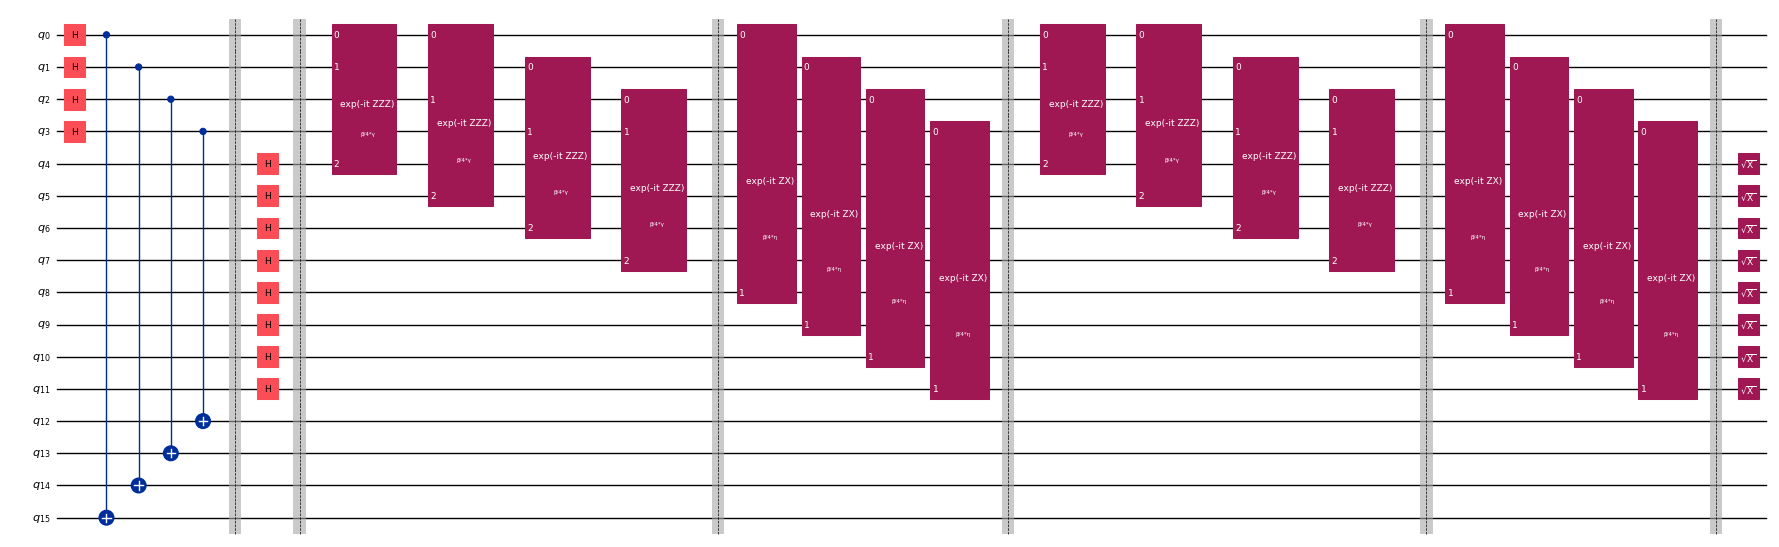

In [14]:
# Inspect raw circuit + observable objects produced by the TFIM core builder
sim_data = tfim_generalized([2, 2], trotter_steps=2)
qc = sim_data['qc']

print("num qubits:", qc.num_qubits)
print("circuit depth:", qc.depth())
print("operation counts:", qc.count_ops())

print("\nSample ZZZ terms:")
print(sim_data['hamiltonian_terms_0'][:3])

print("\nSample ZX terms:")
print(sim_data['hamiltonian_terms_1'][:3])

print("\nH operator term count:", len(sim_data['hamiltonian']))
print("H^2 operator term count:", len(sim_data['hamiltonian_sq']))

qc.draw('mpl', scale=0.5, fold=1000)


### From Core Objects to User API: `models.build_hamiltonian`

In practice, notebook users should not call `tfim_generalized` directly.  
The intended entry point is:

- `models.build_hamiltonian(model, lattice_size, trotter_steps)`

This returns a `GaugeModel` object (from `hamiltonian.py`) that exposes:

- exact spectrum and thermodynamics,
- approximate (circuit-based) thermodynamics,
- ground-state approximations,
- circuit plotting utilities.

Next we use this high-level API to keep the rest of the guide reproducible and compact.


In [16]:
# Exact-only workflow (no estimator backend required)
model = "tfim"
lattice_size = [2, 2]
trotter_steps = 2
beta_vals = np.linspace(0.0, 1.4, 11)

H = models.build_hamiltonian(model, lattice_size, trotter_steps=trotter_steps)

exact_groundstate = H.exact_ground_state()
exact_results = H.get_exact_thermal_quantities(beta_vals)

print(f"Exact ground-state energy: {exact_groundstate:.6f}")
print("\nExact thermal averages <H>(beta):")
for b, e in zip(exact_results['betas'], exact_results['thermal_avgs']):
    print(f"beta={b:>4.2f}  <H>={e:>10.6f}")


Exact ground-state energy: -4.104689

Exact thermal averages <H>(beta):
beta=0.00  <H>=  0.000000
beta=0.14  <H>= -0.686632
beta=0.28  <H>= -1.346609
beta=0.42  <H>= -1.950019
beta=0.56  <H>= -2.469127
beta=0.70  <H>= -2.888338
beta=0.84  <H>= -3.208503
beta=0.98  <H>= -3.442837
beta=1.12  <H>= -3.609595
beta=1.26  <H>= -3.726449
beta=1.40  <H>= -3.807894


### Simulated Thermodynamics: What Happens Under the Hood

Calling `H.get_approximate_thermal_quantities(beta_vals)` performs three stages:

1. Parameter binding + transpilation for each beta.
2. Estimator runs for `H` and `H^2` on each transpiled circuit.
3. Post-processing to compute variance, constant-free free energy, entropy, and fitted thermal curves.

Because the method currently sets Estimator options to finite shots (`default_shots=10000`), you should expect small Monte Carlo-style fluctuations between runs.


Approximate ground-state energy: -3.713520
Exact   <H>(beta_max): -3.807894
Approx. <H>(beta_max): -3.689015
Approx. Var(H)(beta_max): 0.822009


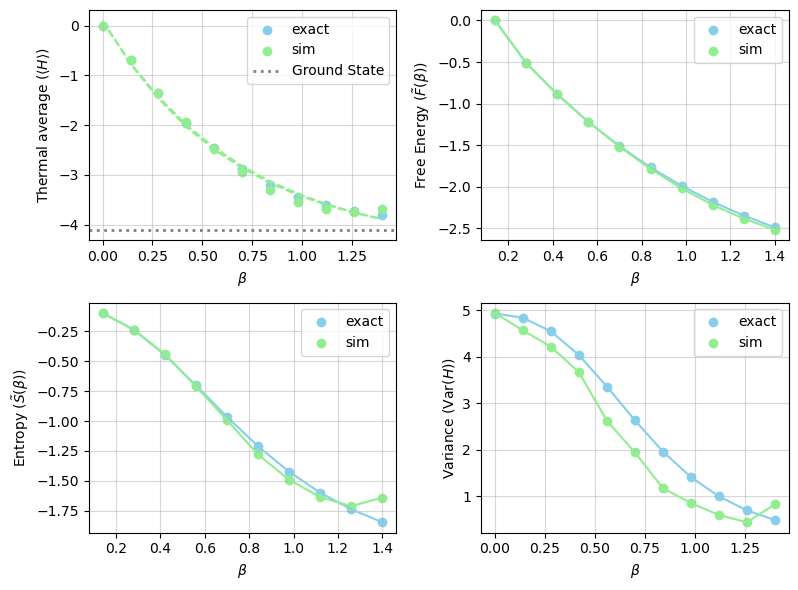

In [18]:
sim_results = H.get_approximate_thermal_quantities(beta_vals)
approx_groundstate = H.approximate_ground_state()

print(f"Approximate ground-state energy: {approx_groundstate:.6f}")
print(f"Exact   <H>(beta_max): {exact_results['thermal_avgs'][-1]:.6f}")
print(f"Approx. <H>(beta_max): {sim_results['thermal_avgs'][-1]:.6f}")
print(f"Approx. Var(H)(beta_max): {sim_results['variance'][-1]:.6f}")

_ = plotting.plot_simulation_results(
    exact_results=exact_results,
    sim_results=sim_results,
    quantities=['thermal_energy', 'free_energy', 'entropy', 'variance'],
    min_eigenval=exact_groundstate,
)


### **Reproducible Workflow and Practical Checks**

The remaining section is intentionally operational.

Goal: help readers avoid common pitfalls when they move from "single demo run" to actual experiments.

We focus on three things:

1. resource feasibility before running,
2. parameter choices (`beta` grid, Trotter depth),
3. repeatable result reporting.


### Feasibility First: Match Lattice Choice to Local Hardware Limits

The package includes `get_system_qubit_limit(memory_factor=0.75)` to estimate a safe simulation ceiling from available RAM.

This is a practical guardrail: the effective qubit count for the Cuomo-style circuits can grow quickly because of purification and auxiliary registers.

In other words, even modest spin lattices can map to significantly wider simulation circuits than expected.


In [21]:
from gauge_simulation.core import get_system_qubit_limit, get_nearest_neighbor_interactions

def tfim_total_qubits(lattice_size):
    n = lattice_size[0] * lattice_size[1]
    n_zz = len(get_nearest_neighbor_interactions(lattice_size))
    n_terms = n + n_zz
    return 2 * n + n_terms

safe_qubit_limit = get_system_qubit_limit()
print(f"Estimated safe local qubit limit: {safe_qubit_limit}")

candidates = [[1, 4], [1, 6], [2, 2], [2, 3], [3, 3]]
print("\nTFIM resource preview")
for ls in candidates:
    total_q = tfim_total_qubits(ls)
    status = "OK" if total_q <= safe_qubit_limit else "Too large"
    print(f"lattice={ls}  total_qubits={total_q:>3}  -> {status}")


Estimated safe local qubit limit: 28

TFIM resource preview
lattice=[1, 4]  total_qubits= 15  -> OK
lattice=[1, 6]  total_qubits= 23  -> OK
lattice=[2, 2]  total_qubits= 16  -> OK
lattice=[2, 3]  total_qubits= 25  -> OK
lattice=[3, 3]  total_qubits= 39  -> Too large


### Choosing `beta` and `trotter_steps` in This Guide

A practical default for this notebook is:

- `beta_vals = np.linspace(0.0, 1.4, 11)`
- `trotter_steps = 2`

Why this range?

- It is wide enough to see cooling behavior toward the ground-state regime.
- It stays close to the package's own approximation convention (`approximate_ground_state` uses `beta=1.4` as an effective cap).
- It keeps runtime reasonable for demo settings.

For publication-level studies, sweep both beta resolution and Trotter depth, then report stability of observables, not just a single run.


In [42]:
# Set run_sweep=True when you want to benchmark multiple Trotter depths.

run_sweep = True

if run_sweep:
    depths = [1, 2, 3]
    beta_vals_sweep = np.linspace(0.0, 1.4, 11)

    print("depth | approx_ground | exact_ground | rel_error")
    print("-" * 52)

    for depth in depths:
        H_tmp = models.build_hamiltonian("tfim", [2, 2], trotter_steps=depth)
        e_exact = H_tmp.exact_ground_state()
        e_approx = H_tmp.approximate_ground_state()
        print(f"{depth:>5} | {e_approx:>13.6f} | {e_exact:>12.6f} | {abs(e_approx - e_exact)/abs(e_exact):>9.6f}")
else:
    print("Set run_sweep=True to execute the Trotter-depth benchmark scaffold.")


depth | approx_ground | exact_ground | rel_error
----------------------------------------------------
    1 |     -3.383338 |    -4.104689 |  0.175738
    2 |     -3.719646 |    -4.104689 |  0.093806
    3 |     -3.740223 |    -4.104689 |  0.088792


### Reporting Results Clearly

For a reader-focused guide, avoid only showing plots. Also print a compact numerical summary at `beta_max`:

- exact and approximate thermal energy,
- approximate variance,
- exact vs approximate ground-state estimate.

This gives immediate quantitative context for each figure and makes reruns easy to compare.


In [40]:
# Compact reporting helper for reproducible comparisons

def summarize_run(exact_results, sim_results, exact_groundstate, approx_groundstate):
    beta_max = exact_results['betas'][-1]
    summary = {
        'beta_max': float(beta_max),
        'exact_groundstate': float(exact_groundstate),
        'approx_groundstate': float(approx_groundstate),
        'exact_thermal_beta_max': float(exact_results['thermal_avgs'][-1]),
        'approx_thermal_beta_max': float(sim_results['thermal_avgs'][-1]),
        'approx_variance_beta_max': float(sim_results['variance'][-1]),
    }

    print("Run summary")
    print("-" * 40)
    for k, v in summary.items():
        print(f"{k:>28}: {v:.6f}" if isinstance(v, float) else f"{k:>28}: {v}")


summarize_run(
    exact_results=exact_results,
    sim_results=sim_results,
    exact_groundstate=exact_groundstate,
    approx_groundstate=approx_groundstate,
)


Run summary
----------------------------------------
                    beta_max: 1.400000
           exact_groundstate: -4.104689
          approx_groundstate: -3.713520
      exact_thermal_beta_max: -3.807894
     approx_thermal_beta_max: -3.689015
    approx_variance_beta_max: 0.822009


### **Where to Extend Next**

At this point, a reader can:

1. reproduce the package's TFIM workflow end-to-end,
2. inspect the internal circuit/Hamiltonian construction,
3. validate exact vs simulated thermodynamic outputs,
4. run feasibility and parameter sanity checks.

Natural next extensions for advanced readers are:

- repeating the same analysis for the `"xy"` model route in `models.build_hamiltonian`,
- increasing lattice size while tracking resource growth,
- testing backend choices and shot budgets,
- documenting convergence behavior versus Trotter depth.
